## Plant pathology

---

### Введение

Яблоки являются одной из самых важных плодовых культур умеренного пояса в мире. Болезни растений (листьев) представляют серьезную угрозу для общей продуктивности яблоневых садов и качества плодов, негативно влияет на их срок хранения. В настоящее время процесс диагностики болезней в яблоневых садах производится людьми путем индивидуального осмотра растений, что требует много времени и средств.

### Цель

Основная цель конкурса — разработать модели на основе машинного обучения для точной классификации заданного изображения листа из тестового набора данных, диагностика конкретной категории заболевания и выявления отдельного заболевания по нескольким симптомам заболевания на одном изображении листа.

COMPETITION WEBSITE: https://www.kaggle.com/c/plant-pathology-2021-fgvc8

Импортируем необходимые библиотеки 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random

In [2]:
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision.utils import save_image

In [3]:
import cv2
from tqdm import tqdm
import shutil 

Зафиксируем случайные величины

In [ ]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

Ознакомимся с исходными данными.

In [5]:
label_df = pd.read_csv('train.csv')

In [6]:
label_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18632 entries, 0 to 18631
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   18632 non-null  object
 1   labels  18632 non-null  object
dtypes: object(2)
memory usage: 291.2+ KB


In [7]:
label_df.head()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


In [8]:
label_df.labels.value_counts()

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

Количество классов

In [9]:
class_qty = label_df.labels.nunique()
class_qty

12

Создадим словарь с классами заболеваний 

In [10]:
labels_map = {}

In [11]:
class_lst = list(label_df.labels.unique())
class_num_lst = [i for i in range(len(class_lst))]
labels_map = dict(zip(class_num_lst, class_lst))
labels_map

{0: 'healthy',
 1: 'scab frog_eye_leaf_spot complex',
 2: 'scab',
 3: 'complex',
 4: 'rust',
 5: 'frog_eye_leaf_spot',
 6: 'powdery_mildew',
 7: 'scab frog_eye_leaf_spot',
 8: 'frog_eye_leaf_spot complex',
 9: 'rust frog_eye_leaf_spot',
 10: 'powdery_mildew complex',
 11: 'rust complex'}

In [12]:
# Функция возвращающая ключ по значению
def get_key(d, value):
    for k, v in d.items():
        if v == value:
            return k

Произведем замену в соответствии со словарем классов. 

In [13]:
inv_map = {v: k for k, v in labels_map.items()}
inv_map

{'healthy': 0,
 'scab frog_eye_leaf_spot complex': 1,
 'scab': 2,
 'complex': 3,
 'rust': 4,
 'frog_eye_leaf_spot': 5,
 'powdery_mildew': 6,
 'scab frog_eye_leaf_spot': 7,
 'frog_eye_leaf_spot complex': 8,
 'rust frog_eye_leaf_spot': 9,
 'powdery_mildew complex': 10,
 'rust complex': 11}

In [14]:
label_df.labels = label_df.labels.map(inv_map)
label_df.head()

,image,labels
0,800113bb65efe69e.jpg,0
1,8002cb321f8bfcdf.jpg,1
2,80070f7fb5e2ccaa.jpg,2
3,80077517781fb94f.jpg,2
4,800cbf0ff87721f8.jpg,3


In [15]:
label_df.to_csv('num_label.csv', index = False)

In [16]:
def batch_visualize(df, batch_width, batch_height, path):
    sample_df = df.sample(batch_width * batch_height)
    image_names = sample_df['image'].values
    labels = sample_df['labels'].values
    plt.figure(figsize=(batch_width*4+1,batch_height*3+1))
    
    for image_ind, (image_name, label) in tqdm(enumerate(zip(image_names, labels))):
        plt.subplot(batch_height, batch_width, image_ind + 1)
        image = cv2.imread(os.path.join(path, image_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.title(f"{labels_map[label]} \n {image.shape[0]} x {image.shape[1]}", fontsize=13)
        plt.axis("off")
    plt.show()

Приведем иллюстрацию нескольких изображений.

12it [00:06,  1.91it/s]


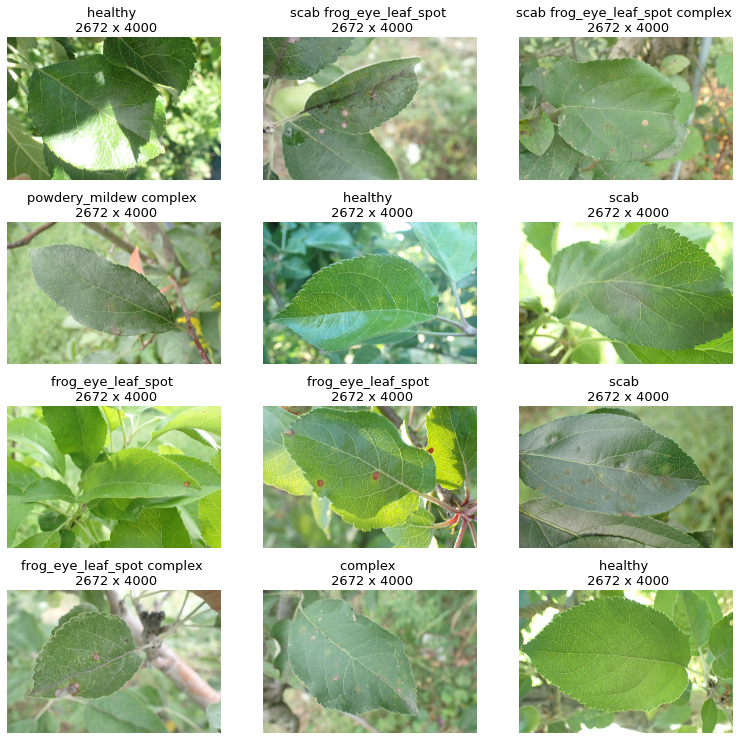

In [17]:
path = 'train_images'
batch_width = 3
batch_height = 4
batch_visualize(label_df,batch_width, batch_height, path)

Для отладки кода и предварительной настроки модели с целью сохранения времени создадим временный датасет в которой войдут копии первых 272 изображений, в случае успешной работы на данном сокращенном датасете, произведем обучение уже на полном наборе изображений.

Создадим папку trial_images куда будут скопированы изображения 

In [18]:
print('Текущая деректория:', os.getcwd())
print('Деректория с размеченными изображениями:',os.path.abspath('train_images'))
os.mkdir('trial_images')
print('Деректория с уменьшенным числом изображений', os.path.abspath('trial_images'))

Текущая деректория: C:\Users\Professional\my_project\Plant Pathology
Деректория с размеченными изображениями: C:\Users\Professional\my_project\Plant Pathology\train_images
Деректория с уменьшенным числом изображений C:\Users\Professional\my_project\Plant Pathology\trial_images


In [19]:
trial_df = label_df.iloc[:272].copy()

In [20]:
dir_from = os.path.abspath('train_images')
dir_to = os.path.abspath('trial_images')

for i in trial_df.image:
    path_from = os.path.join(dir_from, i)
    path_to = os.path.join(dir_to, i)
    shutil.copy(path_from, path_to)

In [21]:
trial_df.to_csv('trial_df.csv', index = False)

Создадим свой класс Dataset

In [22]:
class LeafDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label     

Сформируем трансформер содержащий следующие преобразования валидационных изображений:
- изменим расширение
- сконвертируем в тензор
- произведем нормализацию. Данное форматирования нужно для того, чтобы привести изображения к виду изображений на которых обучался ResNet, в мануал ResNet на сайте pytorch

In [23]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
#     transforms.RandomResizedCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [24]:
val_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [25]:
leaf_ds = LeafDataset(annotations_file='num_label.csv',  # 'trial_df.csv'
                      img_dir='train_images', # 'trial_images'
                     transform = train_transforms)

Посмотрим случайный рисунок из сформированного датасета 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


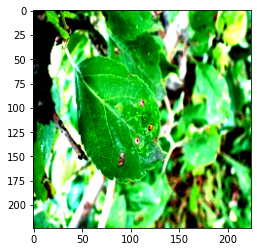

In [26]:
plt.imshow(leaf_ds[1][0].permute(1, 2, 0))

Разделим данные на тренировочную и валидационную под выборки.
Предварительно рассчитаем размер батча с условием, что все батчи будут одинакового размера.

In [27]:
total= len(leaf_ds)
batch_size_available = []
for i in range(32,2000):
    if total%i == 0:
        batch_size_available.append(i)
print(*batch_size_available)  
total

34 68 136 137 274 548 1096


18632

Эксперементальный подбор размера батча очень дорогая операция в плане затрат времени на вычисления, поэтому воспользуемся рекомендацией с https://neurohive.io/ru/novosti/openai-batch-size-ideal/ Где размер оптимального батча находится в районе 1000 изображений. Однако с учетом возможностей видеокарты на которой происходит обучение (gtx1070) остановимся на размере 274 изображения.

In [28]:
train_ds, val_ds = torch.utils.data.random_split(leaf_ds, [15344, 3288])

Нам нужны не тензоры из одного изображения -- нам нужны целые батчи из таких изображений, нужно подавать несколько изображений в нейронку и считать некоторую лосс-функцию сразу по нескольким. Для этой цели используем объект DataLoader, он находится в torch.utils.data.DataLoader, на вход он принимает Dataset, который мы только что получили, а на выходе имеем сформированный батч заданного размера.

In [41]:
batch_size = 274
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=batch_size, shuffle=False, num_workers=0)

In [42]:
len(train_loader), len(val_loader)

(56, 12)

Проверим работу dataloader выполнив обратное преобразования и получив изображение рисунка

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


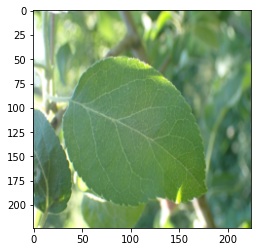

In [31]:
X_batch, y_batch = next(iter(train_loader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean)

Просмотрим все рисунки представленные в 1 батче.

In [32]:
# def show_input(input_tensor, title=''):
#     image = input_tensor.permute(1, 2, 0).numpy()
#     image = std * image + mean
#     plt.imshow(image.clip(0, 1))
#     plt.title(title)
#     plt.show()
#     plt.pause(0.001)

# X_batch, y_batch = next(iter(train_loader))

# for x_item, y_item in zip(X_batch, y_batch):
#     show_input(x_item, title=labels_map[int(y_item)])
# #     show_input(x_item, title=class_names[y_item])

Напишем функцию для тренировки модели.
Но прежде чем приступить непосредственно к функции тренировки, определим функцию для расчёта точности и предсказания класса

In [33]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [34]:
def class_predictor(y_pred):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    return y_pred_tags

In [35]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_loader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_loader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Произведем итерацию данных
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = class_predictor(preds)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

Создадим модель на основе существующей обученной модели ResNet18, которая как это ни странно показала лучше результат по точности по сравнению с ResNet50. В качестве последнего выходного слоя нейронов примем полно связный слой из 12 нейронов в соответствии с количеством классов.

In [37]:
model = models.resnet18(pretrained=True)

# Заморозим параметры в базовой модели, т.к. в обучении они не нуждаются
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 12)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [38]:
print(device)

cuda:0


In [39]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Уменьшаем шаг обучение каждые 5 эпох
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [43]:
train_model(model, loss, optimizer, scheduler, num_epochs=10)

Epoch 0/9:


100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [1:12:49<00:00, 78.02s/it]

train Loss: 1.6239 Acc: 0.4695



100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [14:07<00:00, 70.66s/it]

val Loss: 1.3333 Acc: 0.6068
Epoch 1/9:



100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [1:05:24<00:00, 70.08s/it]

train Loss: 1.1977 Acc: 0.6457



100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [14:01<00:00, 70.15s/it]

val Loss: 1.1315 Acc: 0.6624
Epoch 2/9:



100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [1:05:14<00:00, 69.90s/it]

train Loss: 1.0596 Acc: 0.6819



100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [14:00<00:00, 70.01s/it]

val Loss: 1.0339 Acc: 0.6898
Epoch 3/9:



100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [1:05:07<00:00, 69.78s/it]

train Loss: 0.9927 Acc: 0.6992



100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [13:58<00:00, 69.84s/it]

val Loss: 0.9866 Acc: 0.7035
Epoch 4/9:



100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [1:04:38<00:00, 69.26s/it]

train Loss: 0.9394 Acc: 0.7106



100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [13:50<00:00, 69.19s/it]

val Loss: 0.9460 Acc: 0.7120
Epoch 5/9:



100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [1:04:15<00:00, 68.84s/it]

train Loss: 0.9072 Acc: 0.7222



100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [13:44<00:00, 68.67s/it]

val Loss: 0.9379 Acc: 0.7111
Epoch 6/9:



100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [1:04:45<00:00, 69.39s/it]

train Loss: 0.9028 Acc: 0.7207



100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [13:56<00:00, 69.72s/it]

val Loss: 0.9398 Acc: 0.7114
Epoch 7/9:



100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [1:09:18<00:00, 74.25s/it]

train Loss: 0.9033 Acc: 0.7236



100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [14:22<00:00, 71.88s/it]

val Loss: 0.9413 Acc: 0.7135
Epoch 8/9:



100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [1:07:11<00:00, 71.99s/it]

train Loss: 0.8972 Acc: 0.7212



100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [14:25<00:00, 72.11s/it]

val Loss: 0.9337 Acc: 0.7147
Epoch 9/9:



100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [1:12:37<00:00, 77.81s/it]

train Loss: 0.8895 Acc: 0.7284



100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [15:34<00:00, 77.88s/it]

val Loss: 0.9261 Acc: 0.7138


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 0/9:
100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [1:12:49<00:00, 78.02s/it]
train Loss: 1.6239 Acc: 0.4695

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [14:07<00:00, 70.66s/it]
val Loss: 1.3333 Acc: 0.6068
Epoch 1/9:

100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [1:05:24<00:00, 70.08s/it]
train Loss: 1.1977 Acc: 0.6457

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [14:01<00:00, 70.15s/it]
val Loss: 1.1315 Acc: 0.6624
Epoch 2/9:

100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [1:05:14<00:00, 69.90s/it]
train Loss: 1.0596 Acc: 0.6819

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [14:00<00:00, 70.01s/it]
val Loss: 1.0339 Acc: 0.6898
Epoch 3/9:

100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [1:05:07<00:00, 69.78s/it]
train Loss: 0.9927 Acc: 0.6992

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [13:58<00:00, 69.84s/it]
val Loss: 0.9866 Acc: 0.7035
Epoch 4/9:

100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [1:04:38<00:00, 69.26s/it]
train Loss: 0.9394 Acc: 0.7106

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [13:50<00:00, 69.19s/it]
val Loss: 0.9460 Acc: 0.7120
Epoch 5/9:

100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [1:04:15<00:00, 68.84s/it]
train Loss: 0.9072 Acc: 0.7222

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [13:44<00:00, 68.67s/it]
val Loss: 0.9379 Acc: 0.7111
Epoch 6/9:

100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [1:04:45<00:00, 69.39s/it]
train Loss: 0.9028 Acc: 0.7207

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [13:56<00:00, 69.72s/it]
val Loss: 0.9398 Acc: 0.7114
Epoch 7/9:

100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [1:09:18<00:00, 74.25s/it]
train Loss: 0.9033 Acc: 0.7236

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [14:22<00:00, 71.88s/it]
val Loss: 0.9413 Acc: 0.7135
Epoch 8/9:

100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [1:07:11<00:00, 71.99s/it]
train Loss: 0.8972 Acc: 0.7212

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [14:25<00:00, 72.11s/it]
val Loss: 0.9337 Acc: 0.7147
Epoch 9/9:

100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [1:12:37<00:00, 77.81s/it]
train Loss: 0.8895 Acc: 0.7284

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [15:34<00:00, 77.88s/it]
val Loss: 0.9261 Acc: 0.7138

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer3): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=512, out_features=12, bias=True)
)

Сохраним модель

In [44]:
torch.save(model.state_dict(), 'model_10epoch.pth')

Сохраним параметры модели

In [45]:
torch.save(model.state_dict(), 'model_10epoch_dict.pth');

Во время обучения, к сожалению, не были сохранены истории изменения метрик. В связи с чем придется данные вводить в ручную.

In [106]:
lst = ['1 train Loss: 1.6239 Acc: 0.4695 val Loss: 1.3333 Acc: 0.6068 ',
'2 train Loss: 1.1977 Acc: 0.6457 val Loss: 1.1315 Acc: 0.6624', 
'3 train Loss: 1.0596 Acc: 0.6819  val Loss: 1.0339 Acc: 0.6898 ',
'4 train Loss: 0.9927 Acc: 0.6992 val Loss: 0.9866 Acc: 0.7035',
'5 train Loss: 0.9394 Acc: 0.7106 val Loss: 0.9460 Acc: 0.7120',
'6 train Loss: 0.9072 Acc: 0.7222 val Loss: 0.9379 Acc: 0.7111',
'7 train Loss: 0.9028 Acc: 0.7207 val Loss: 0.9398 Acc: 0.7114',
'8 train Loss: 0.9033 Acc: 0.7236 val Loss: 0.9413 Acc: 0.7135',
'9 train Loss: 0.8972 Acc: 0.7212 val Loss: 0.9337 Acc: 0.7147',
'10 train Loss: 0.8895 Acc: 0.7284 val Loss: 0.9261 Acc: 0.7138']

In [107]:
lst = list(map(lambda x: x.split(), lst))

In [177]:
history = pd.DataFrame(lst)
history = history.drop(columns = [1,2,4,6,7,9],axis = 1)
history.rename(columns = {0 : 'epoch', 3 : 'train_loss',  5 : 'train_acc', 8 : 'val_loss', 10 : 'val_acc'}, inplace = True)
history = history.astype(float)

In [197]:
def plot_hist(history):
    
    epoch = history['epoch']
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    
    
    plt.style.use('ggplot')
    plt.figure(figsize=(20, 10))
    plt.rcParams['font.size'] = '20'

    plt.subplot(1, 2, 1)
    plt.plot(epoch,acc, label='Training Accuracy')
    plt.plot(epoch,val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
#     plt.ylim([0, 2])
    plt.title('Training and Validation Accuracy')
    plt.xlabel('epoch')

    plt.subplot(1, 2, 2)
    plt.plot(epoch,loss, label='Training Loss')
    plt.plot(epoch,val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Categorical Crossentropy')
    plt.ylim([min(plt.ylim()), max(plt.ylim())])
    plt.title('Training and Validation Loss')

    plt.xlabel('epoch')
    plt.savefig('evaluation.jpg')
    plt.show()

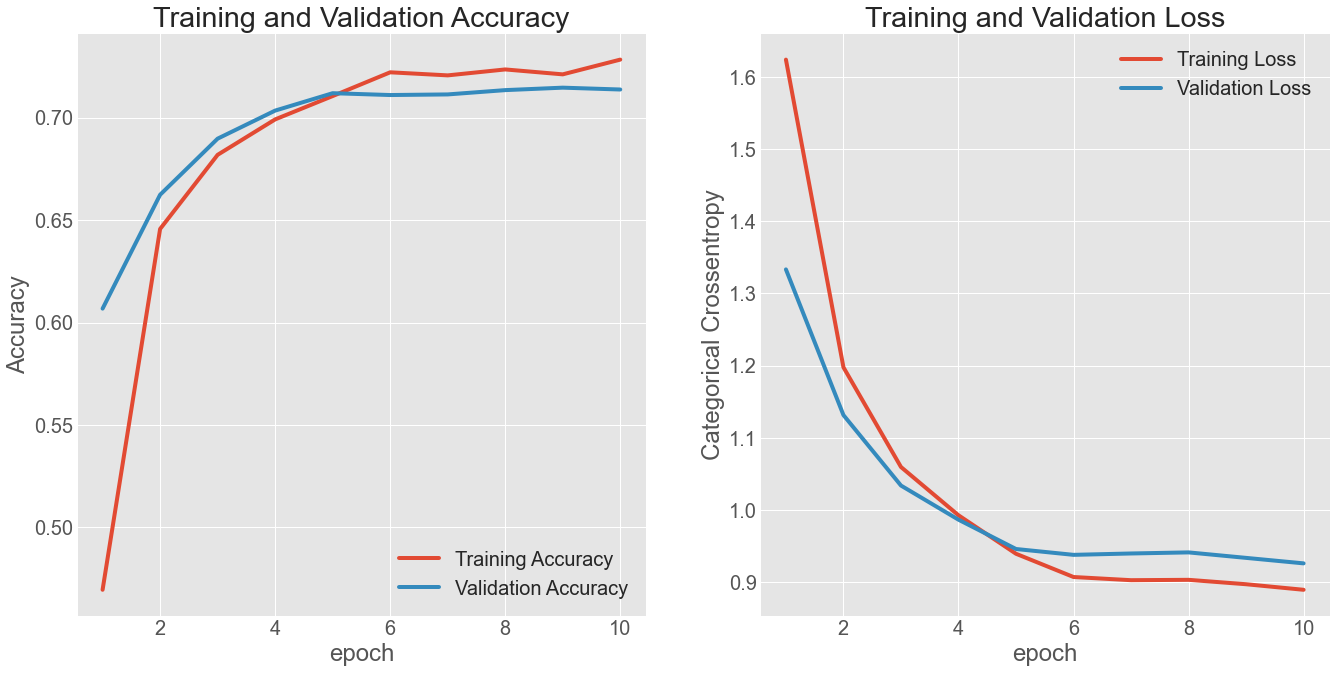

In [198]:
plot_hist(history)

## Вывод

Значение точности и функции потерь на обучающей и валидационной выборках достигли своей "полки" и в дальнейшем изменяются не значительно, нет чрезмерных значений точности на обучающий выборке с их одновременным просаживанием на валидационной. Таким образом можно говорить, что модель явно не переобучена. Так же видно, что после 5 эпохи качество метрик изменятся слабо, следовательно дальнейшее увеличение метрик не является целесообразным. Можно сказать, что на данным момент времени модель обучена оптимально.

---

## Подготовка данных для Kaggle Submission

Подготовим данные для проведения теста. Тестовые данные для пользователя закрыты, представленна лишь небольшая подвыборка для правильного оформления предсказаний. 

In [46]:
test_img_lst = os.listdir(path="test_images")
test_img_labels = list(map(lambda x: 'unknown', test_img_lst))

In [47]:
data = [test_img_lst, test_img_labels] 
columns = ['image' ,'labels']
# index = [1, 2, 3]

In [56]:
test_df = pd.DataFrame(data, columns).T
test_df

,image,labels
0,001.jpg,unknown
1,002.jpg,unknown
2,003.jpg,unknown
3,004.jpg,unknown
4,005.jpg,unknown
5,006.jpg,unknown
6,007.jpg,unknown
7,85f8cb619c66b863.jpg,unknown
8,ad8770db05586b59.jpg,unknown
9,c7b03e718489f3ca.jpg,unknown


In [49]:
# test_df.labels = [0,1,1,1,1,1,0,1,1,1]

In [76]:
test_df.labels = test_df.image

In [79]:
test_df.to_csv('test_df.csv', index = False)

In [80]:
test_leaf_ds = LeafDataset(annotations_file='test_df.csv', 
                      img_dir='test_images',
                     transform = val_transforms)

In [81]:
batch_size = 1
test_loader = torch.utils.data.DataLoader(
    test_leaf_ds, batch_size=batch_size, shuffle=True, num_workers=0)

In [82]:
len(test_loader)

10

In [91]:
model.eval()

test_pred = []
image_name = []

for inputs, image in tqdm(test_loader):
    inputs = inputs.to(device)
    image_name.append(image[0]) 
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_pred.append(
        class_predictor(preds).data.cpu().numpy())
    
test_pred = np.concatenate(test_pred)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.56it/s]


In [92]:
test_pred, image_name

(array([2, 4, 5, 3, 4, 0, 2, 5, 2, 0], dtype=int64),
 ['005.jpg',
  '002.jpg',
  'c7b03e718489f3ca.jpg',
  'ad8770db05586b59.jpg',
  '85f8cb619c66b863.jpg',
  '001.jpg',
  '006.jpg',
  '004.jpg',
  '003.jpg',
  '007.jpg'])

In [95]:
submit_df = pd.DataFrame([image_name, test_pred], columns).T
submit_df.labels = submit_df.labels.map(labels_map)
submit_df = submit_df.sort_values(by = 'image')

In [96]:
submit_df

,image,labels
5,001.jpg,healthy
1,002.jpg,rust
8,003.jpg,scab
7,004.jpg,frog_eye_leaf_spot
0,005.jpg,scab
6,006.jpg,scab
9,007.jpg,healthy
4,85f8cb619c66b863.jpg,rust
3,ad8770db05586b59.jpg,complex
2,c7b03e718489f3ca.jpg,frog_eye_leaf_spot


In [ ]:
# save prediction into csv file
submit_df.to_csv("./submission.csv", index=False)